In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
# Define constants
DATA_DIR = 'images/'
EMOTIONS = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprised']
IMG_SIZE = 48

In [3]:
# Function to load and preprocess images
def load_data():
    images = []
    labels = []
    
    for emotion_label, emotion in enumerate(EMOTIONS):
        emotion_dir = os.path.join(DATA_DIR, str(emotion_label))
        if os.path.isdir(emotion_dir):
            for img_file in os.listdir(emotion_dir):
                img_path = os.path.join(emotion_dir, img_file)
                img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                images.append(img_resized)
                labels.append(emotion_label)
        else:
            print(f"Directory not found for emotion {emotion}: {emotion_dir}")
        
    return np.array(images), np.array(labels)

# Load the data
images, labels = load_data()


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize the pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

# Reshape data for CNN input
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)


Number of images: 64
Shape of images array: (64, 48, 48)
Number of labels: 64


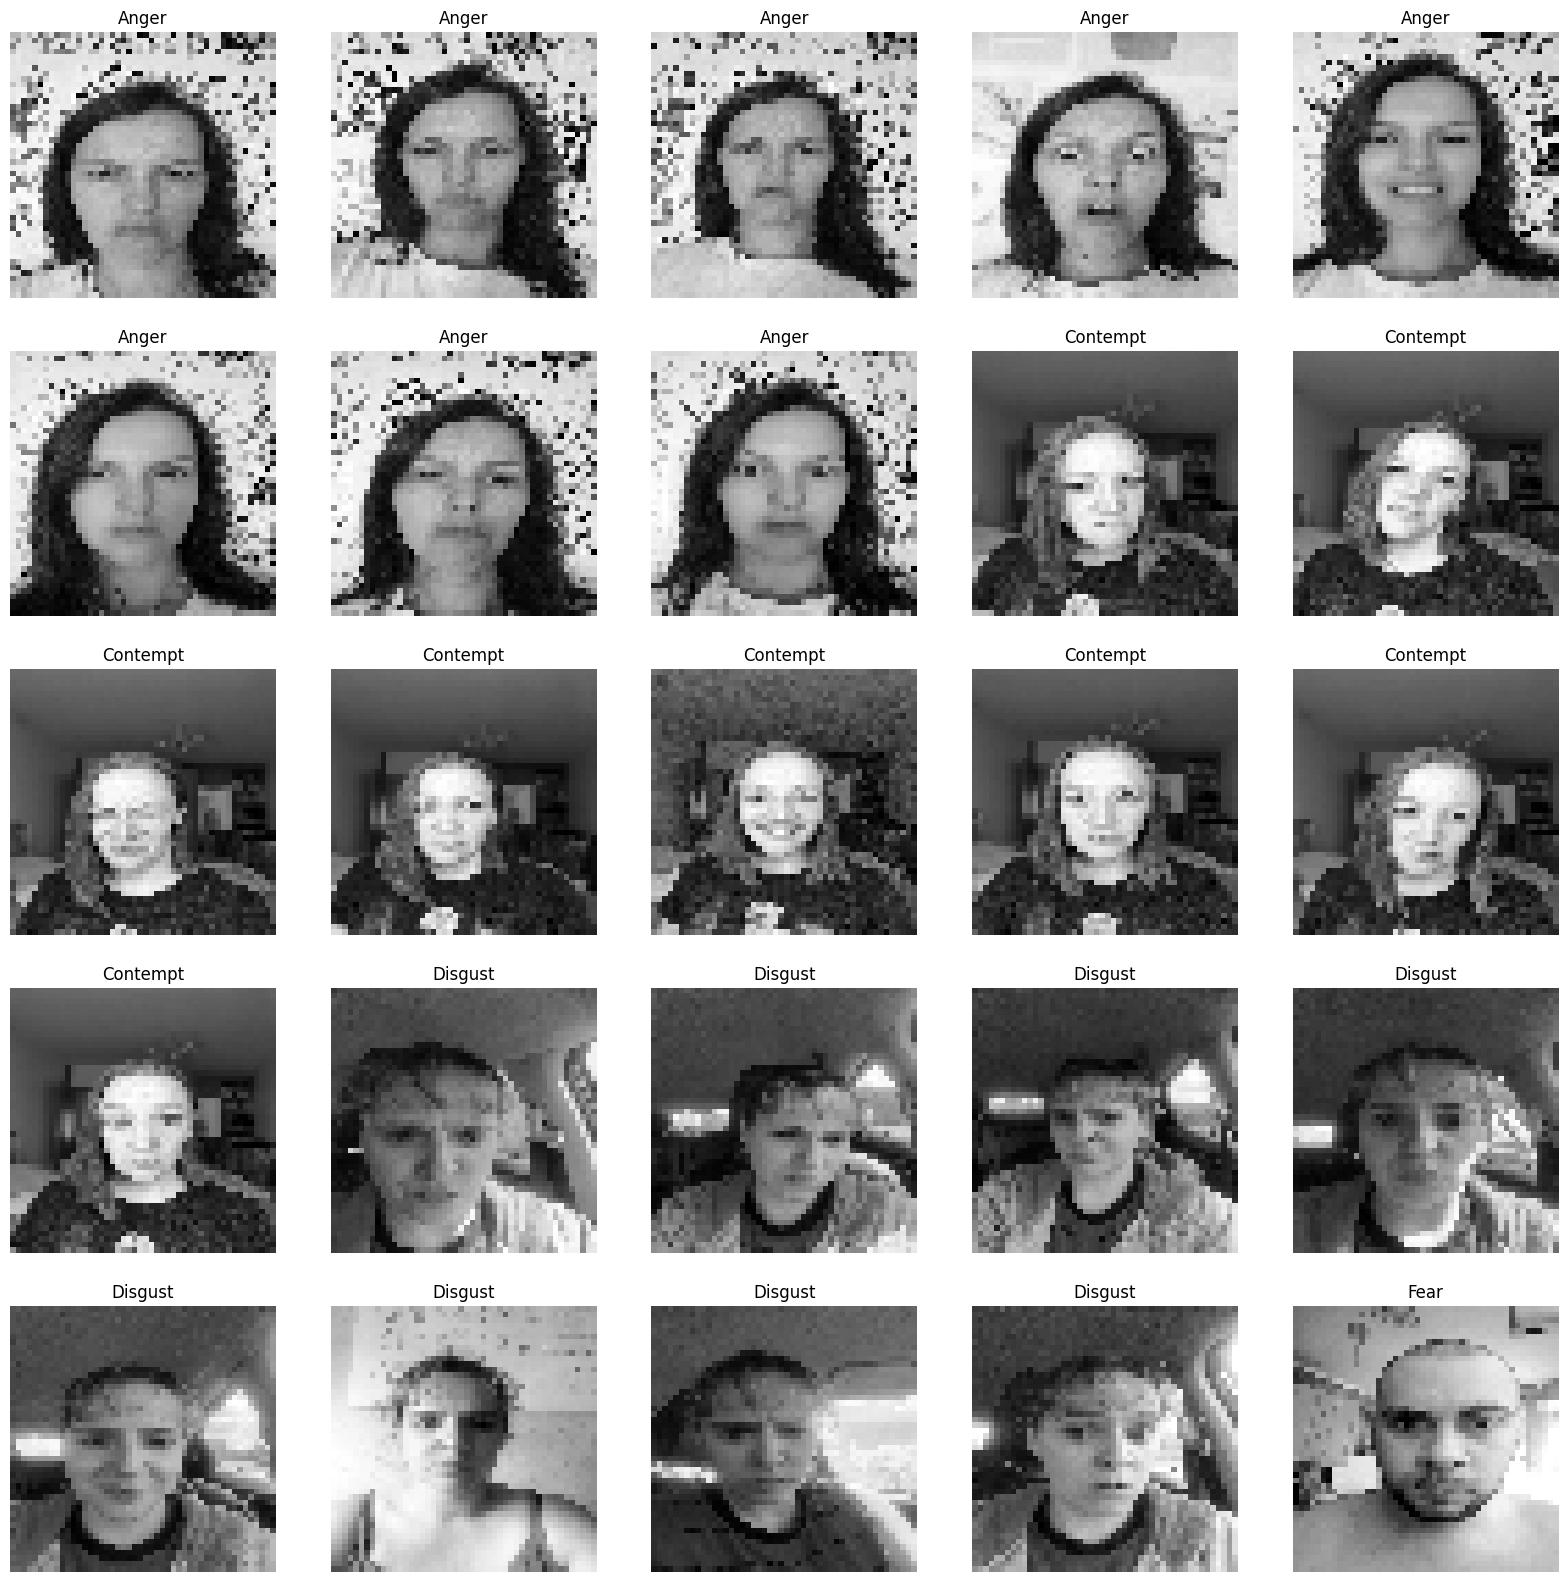

In [4]:
# Print information about the dataset
print("Number of images:", len(images))
print("Shape of images array:", images.shape)
print("Number of labels:", len(labels))

# Print sample images and their corresponding labels
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(EMOTIONS[labels[i]])
    plt.axis('off')
plt.show()

In [5]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

In [6]:
# Define the CNN model
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    layers.Dense(len(EMOTIONS), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)       

In [8]:
# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
2/2 [==============================] - 0s 151ms/step - loss: 1.9544 - accuracy: 0.2745 - val_loss: 1.8119 - val_accuracy: 0.4615
Epoch 2/50
2/2 [==============================] - 0s 96ms/step - loss: 1.8671 - accuracy: 0.2745 - val_loss: 1.7147 - val_accuracy: 0.5385
Epoch 3/50
2/2 [==============================] - 0s 69ms/step - loss: 1.7865 - accuracy: 0.4118 - val_loss: 1.6327 - val_accuracy: 0.5385
Epoch 4/50
2/2 [==============================] - 0s 98ms/step - loss: 1.7211 - accuracy: 0.4118 - val_loss: 1.4777 - val_accuracy: 0.4615
Epoch 5/50
2/2 [==============================] - 0s 100ms/step - loss: 1.6696 - accuracy: 0.3725 - val_loss: 1.3450 - val_accuracy: 0.7692
Epoch 6/50
2/2 [==============================] - 0s 100ms/step - loss: 1.5657 - accuracy: 0.4902 - val_loss: 1.2225 - val_accuracy: 0.3846
Epoch 7/50
2/2 [==============================] - 0s 87ms/step - loss: 1.4008 - accuracy: 0.3922 - val_loss: 1.0095 - val_accuracy: 0.6923
Epoch 8/50
2/2 [========

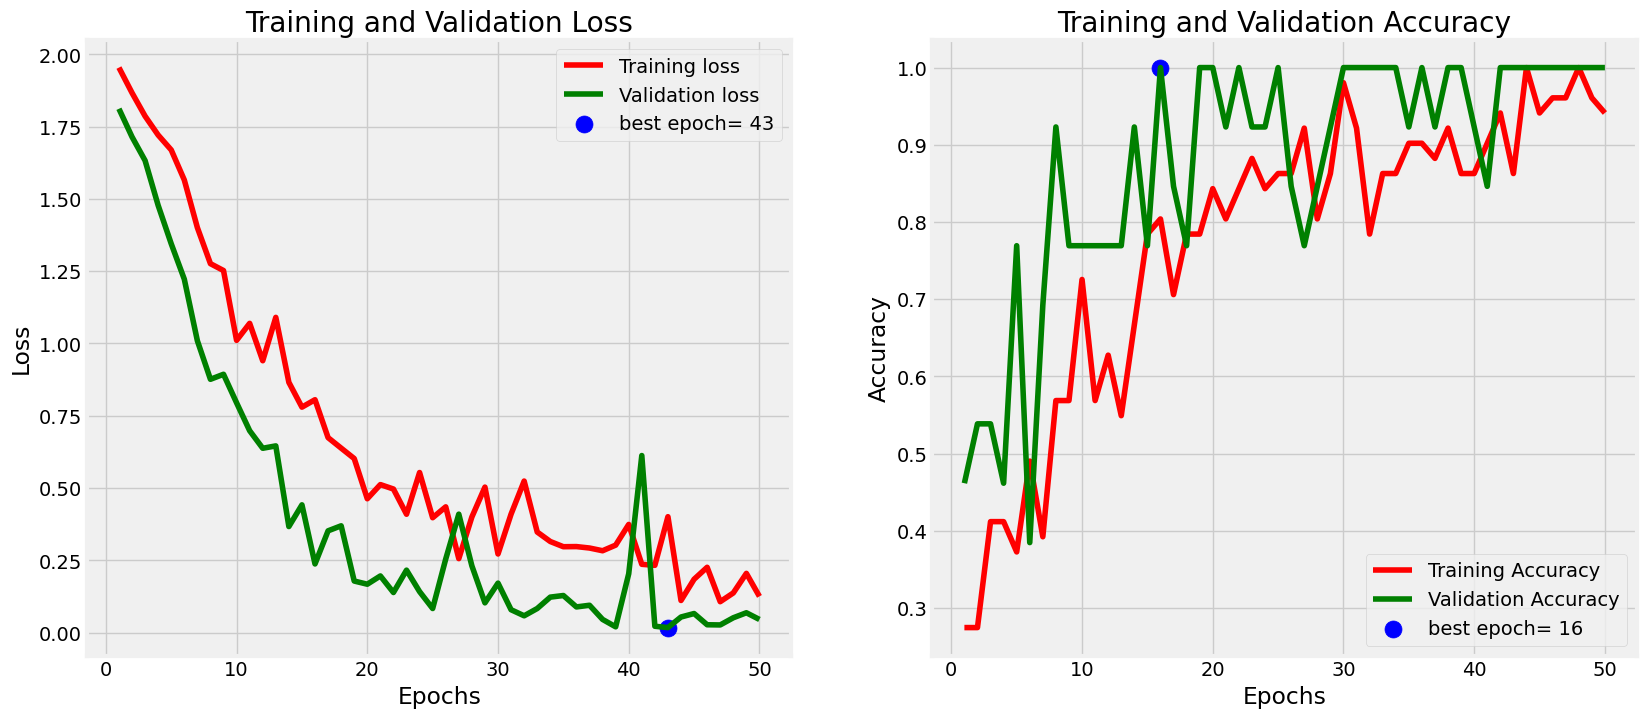

In [9]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [10]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1/1 - 0s - loss: 0.0453 - accuracy: 1.0000 - 21ms/epoch - 21ms/step
Test Loss: 0.04531394690275192
Test Accuracy: 1.0


In [11]:
from sklearn.metrics import classification_report

# Make predictions on the test set
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Print classification report
print(classification_report(y_test, predicted_labels, target_names=EMOTIONS))


1/1 [==============================] - 0s 106ms/step
              precision    recall  f1-score   support

       Anger       1.00      1.00      1.00         2
    Contempt       1.00      1.00      1.00         2
     Disgust       1.00      1.00      1.00         1
        Fear       1.00      1.00      1.00         1
       Happy       1.00      1.00      1.00         1
     Neutral       1.00      1.00      1.00         2
         Sad       1.00      1.00      1.00         1
   Surprised       1.00      1.00      1.00         3

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



In [15]:
#print the training and validation accuracy
print("Training accuracy: ", tr_acc[-1])
print("Validation accuracy: ", val_acc[-1])

Training accuracy:  0.9411764740943909
Validation accuracy:  1.0


In [16]:
#print the training and validation loss
print("Training loss: ", tr_loss[-1])
print("Validation loss: ", val_loss[-1])

Training loss:  0.12508563697338104
Validation loss:  0.04531394690275192


1/1 [==============================] - 0s 33ms/step


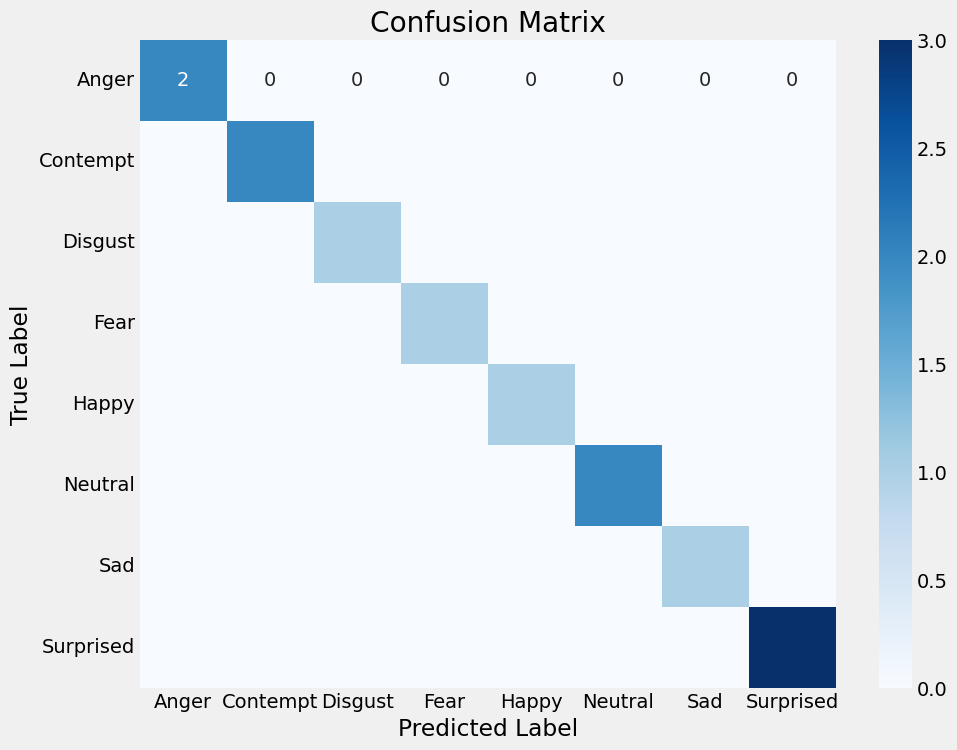

In [12]:
# Make predictions on the test set
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=EMOTIONS, yticklabels=EMOTIONS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 0s 19ms/step


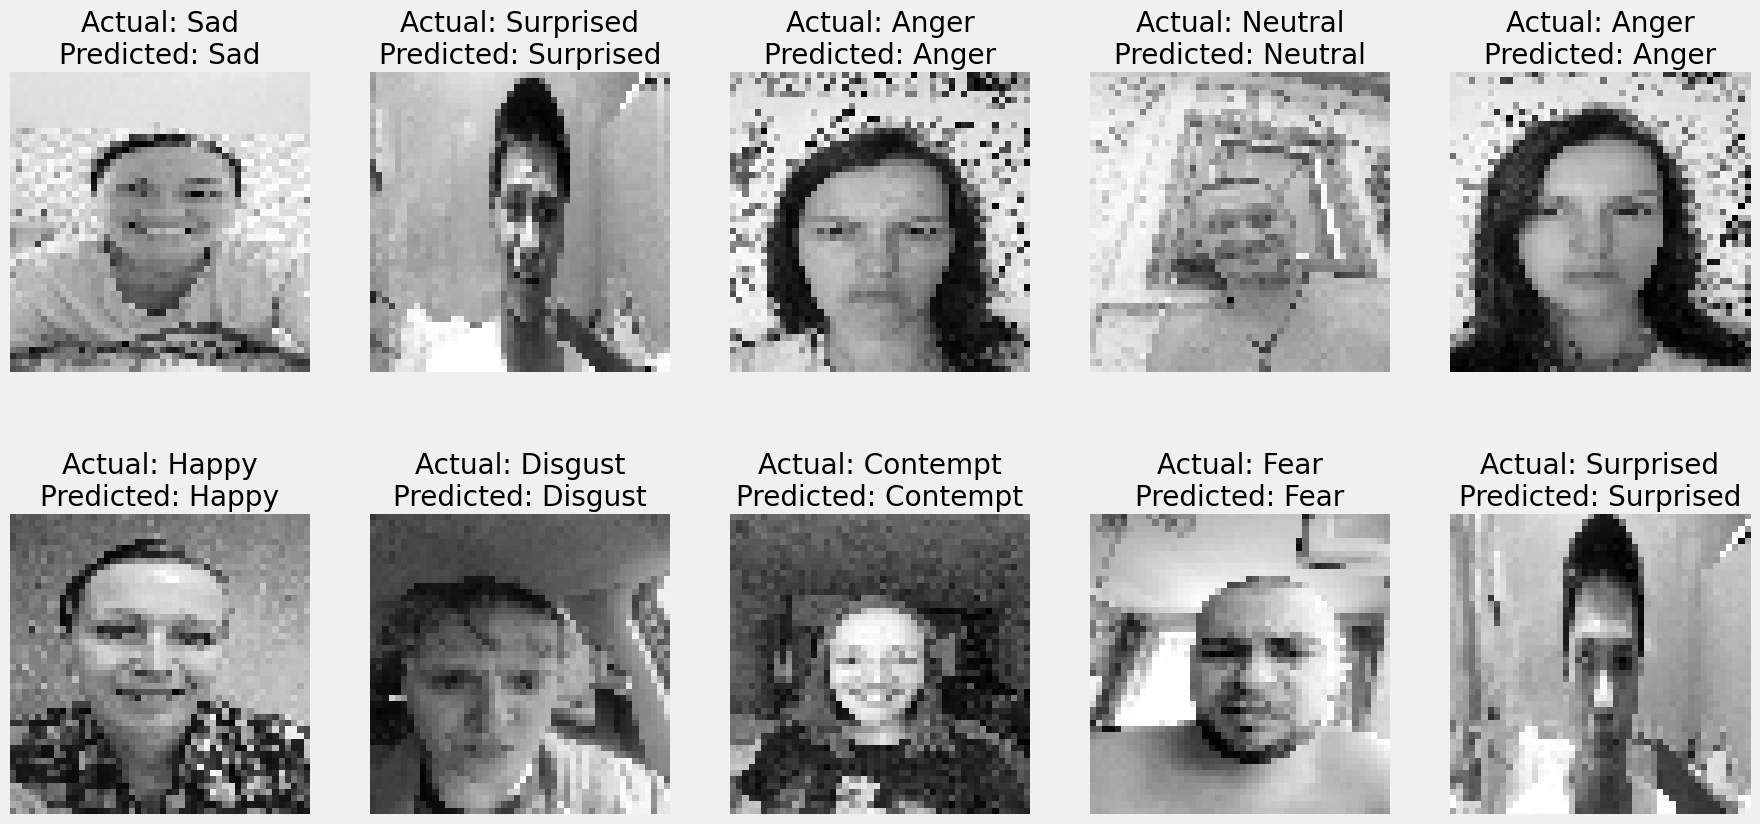

In [13]:
import matplotlib.pyplot as plt

# Make predictions on the test set
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Function to display images with predicted and actual labels
def display_images(images, actual_labels, predicted_labels, emotions, num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        # Since the images are grayscale, we reshape them to (48, 48)
        img = images[i].reshape(IMG_SIZE, IMG_SIZE)
        plt.imshow(img, cmap='gray')
        plt.title(f"Actual: {emotions[actual_labels[i]]}\nPredicted: {emotions[predicted_labels[i]]}")
        plt.axis('off')
    plt.show()

# Display the images with predicted and actual labels
display_images(X_test, y_test, predicted_labels, EMOTIONS)

In [14]:
#save the model
model.save('emotion_detection_model.h5')

c:\Users\saidi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
